---
title: "Check In 2"
format: html
---

## Scraping
I have scraped the data in a seperate script. I have included it here commented out so it is visible how I did it but there's no need to rerun it of course. I have elected to use Steam data from user reviews. I am interested in comparing trends between reviews of games that have female protagonists versus games with male protagonists. Finding games with female protagonists was the hardest part, so I selected {list}. Then I selected games with male protagonists that I tried to map 1 to 1 with the female protagonist games (same year ± 1, similar genre, etc.) as these are likely to be potentially confounding variables in comparison.The question I am attempting to answer is "Does review content differ depending on whether the lead protagonist of a video game is female or not?"

In [1]:
%%capture
"""
import requests
import urllib.parse
from time import sleep
import os
from dotenv import load_dotenv
from urllib.parse import quote
import pickle
import re

load_dotenv()

KEY = os.getenv('KEY')

def getUserReviews(reviewAppid, params):
    #userReviewsUrl = f'https://store.steampowered.com/appreviews/{reviewAppid}'
    cursor = params['cursor']
    userReviewsUrl = f"https://store.steampowered.com/appreviews/{reviewAppid}?json=1&cursor={cursor}&filter_offtopic_activity=0&filter=recent&language=english&num_per_page=100"
    userReviewsResponse = requests.get(
            userReviewsUrl,
            #params=params
        )
    print(f"Status Code: {userReviewsResponse.status_code}")
    

    if (userReviewsResponse.status_code != 200) and (userReviewsResponse.status_code != 429):
        print(f'Fail to get response for {reviewAppid}. Status code: {userReviewsResponse.status_code}')
        return {'success' : 0}, userReviewsResponse.status_code
    try:
        userReviews = userReviewsResponse.json()
    except:
        return {"success": 0}, userReviewsResponse.status_code
    return userReviews, userReviewsResponse.status_code

gamesOfInterestFemale = {
    '870780' : 'Control Ultimate Edition',
    '752590' : 'A Plague Tale Innocence',
    '750920' : 'Shadow of the Tomb Raider',
    '414340' : "Hellblade: Senua's Sacrifice",
    '524220' : 'Nier:Automata',
    '1265920' : 'Life is Strange Remastered',
}

gamesOfInterestMale = {
    '108710' : 'Alan Wake',
    '532210' : 'Life is Strange 2',
    '1659420' : 'Uncharted: Legacy of Thieves Collection',
    '814380' : 'Sekiro: Shadows Die Twice - GOTY Edition',
    '1687950' : 'Persona 5 Royal',
    '2050650' : 'Resident Evil 4'
}

allGamesOfInterest = {
    'female' : gamesOfInterestFemale,
    'male' : gamesOfInterestMale    
}

def parseResponse(gameId, gameTitle):
    reviewsSkipped = 0
    reviews = []
    name = gameTitle
    reviewMax = 100
    #reviewMax = 20
    params = {
            #'json' : 1,
            #'language' : 'english',
            'cursor' : '*',
            #'filter_offtopic_activity' : 1,
            #'num_per_page': 100,
            #'key' : KEY,
            #'filter' : 'recent'
    }
    while(True):
        reviewMin = reviewMax - 100
        #reviewMin = reviewMax - 20
        print(f"Getting Reviews: {reviewMin}-{reviewMax} for {name}")
        print(f"Params: {params}")
        response,status = getUserReviews(gameId,params)
        if status == 429:
            print(f"Rate Limiting")
            sleep(300)
            continue
        print(f"Extracted {len(response['reviews'])} reviews")
        #print(response['reviews'])
        #if response['success'] != 1:
        #    print(f'Fail to get response for {gameId}.')
        #    return {'allReviewsGot' : 0}, []

        for review in response['reviews']:
            try:
                recommendationId = review['recommendationid']

                timestampCreated = review['timestamp_created']
                timestampUpdated = review['timestamp_updated']

                authorSteamId = review['author']['steamid']
                playtimeForever = review['author']['playtime_forever']
                playtimeLastTwoWeeks = review['author']['playtime_last_two_weeks']
                playtimeAtReviewMinutes = review['author']['playtime_at_review']
                lastPlayed = review['author']['last_played']

                reviewText = review['review']
                votedUp = review['voted_up']
                votesUp = review['votes_up']
                votesFunny = review['votes_funny']
                weightedVoteScore = review['weighted_vote_score']
                steamPurchase = review['steam_purchase']
                receivedForFree = review['received_for_free']
                writtenDuringEarlyAccess = review['written_during_early_access']

                myReviewDict = {
                    'recommendationid': recommendationId,
                    'authorSteamid': authorSteamId,
                    'playtimeAtReviewMinutes': playtimeAtReviewMinutes,
                    'playtimeForeverMinutes': playtimeForever,
                    'playtimeLastTwoWeeksMinutes': playtimeLastTwoWeeks,
                    'lastPlayed': lastPlayed,

                    'reviewText': reviewText,
                    'timestampCreated': timestampCreated,
                    'timestampUpdated': timestampUpdated,

                    'votedUp': votedUp,
                    'votesUp': votesUp,
                    'votesFunny': votesFunny,
                    'weightedVoteScore': weightedVoteScore,
                    'steamPurchase': steamPurchase,
                    'receivedForFree': receivedForFree,
                    'writtenDuringEarlyAccess': writtenDuringEarlyAccess,
                }
                reviews.append(myReviewDict)
            except:
                print("Skipped Review")
                reviewsSkipped += 1
                print(f'Reviews Skipped: {reviewsSkipped}')
        if response['cursor'] == params['cursor']:
            return reviews
        
        if response['query_summary']['num_reviews'] == 0:
            print(f'No more reviews: {response}')
            return reviews
        
        try:
            cursor = response['cursor']
            print(cursor)
            params['cursor'] = quote(cursor)
            print(params['cursor'])
        except:
            return reviews
        
        reviewMax += 100
        #reviewMax += 20
        sleep(1.5)



steamIDs = ['870780','752590','750920','414340','524220','1265920','108710','532210','1659420','814380','1687950','2050650']

for key,items in allGamesOfInterest.items():
        for key,val in items.items():
            reviews = parseResponse(key,val)
            title = val.strip().replace(" ","_").lower()
            titleClean = re.sub(r'[^\w_. -]', '_', title)
            data = {key : reviews}
            with open(f'./data/pkl/{titleClean}.pkl','wb') as f:
                pickle.dump(data,f)
            try:
                steamIDs.remove(key)
                print(f"{len(steamIDs)} games left")
            except:
                print("Crying is a free action")
"""

## Cleaning
Due to the nature of steam being a place of informal reviews, a lot of text cleaning has to be done to the reviews which ultimately does reduce the amount of data but the data available is relatively clean. I have commented out my process but it is essentially: 
load -> remove excess scraped data -> remove reviews missing elements to filter by -> filter by playtime >3hrs and within two week palytime of review writing >15 mins -> remove emoji and extra whitespace -> remove links -> clear out non enlish reviews (apparently steam language tags aren't very good)

In [2]:
import pickle
import re
from collections import Counter
from lingua import Language, LanguageDetectorBuilder

In [8]:
def load(file):
    with open(file,'rb') as f:
        return pickle.load(f)

def extractData(review):
    recId = review['recommendationid']
    reviewPlaytime = review['playtimeAtReviewMinutes']
    earlyAccessReview = review['writtenDuringEarlyAccess']
    votedUp = review['votedUp']
    helpfulness = review['weightedVoteScore']
    recentPlaytime = review['playtimeLastTwoWeeksMinutes']
    
    text = review['reviewText']
    
    trimmedData = {
        'id' : recId,
        'playtime' : reviewPlaytime,
        'recentPlaytime' : recentPlaytime,
        'earlyAccess' : earlyAccessReview,
        'votedUp' : votedUp,
        'helpfulness' : helpfulness
    }
    
    return trimmedData, text

def isEnglish(string):
  return string.isascii()

def cleanData(reviews):
    languages = [Language.ENGLISH, Language.SPANISH, Language.PORTUGUESE]
    detector = LanguageDetectorBuilder.from_languages(*languages).build()
    outReviews = []
    for review in reviews:
        data, text = extractData(review)
        if (data['playtime'] == None) or (data['recentPlaytime'] == None):
            continue
        elif (int(data['playtime']) >= 180) and (int(data['recentPlaytime']) >= 15):
            #Removes emoji like characters
            normText = re.sub(r"[^\w\s\.,!?;:\(\)\[\]\-\+=\{\}\|\/\<\>.]", '', text)
            #Remove links
            cleanText = re.sub(r"\[.*?\]|(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])", '', normText)
            #Remove excess whitespace
            cleanText = ' '.join(cleanText.split())
            #Remove reviews that follow a specific pattern that results in odd text
            if bool(re.search('---.*?---', cleanText)):
                continue
            #Check if string is ascii encoded
            elif isEnglish(cleanText):
                #Ignore reviews with less than 5 words
                if sum(Counter(cleanText.split()).values()) < 5:
                    continue
                #Make sure review is in english
                elif detector.detect_language_of(cleanText) != Language.ENGLISH:
                    continue
                else:
                    outReviews.append([data, cleanText])
    return outReviews

## Preprocessing
Now we can finally do some nlp preprocessing using spaCy and generate plots and data using Wordcloud and Gensim

Data structure for the preprocessed data is a dictionary of reviews, where the first 6 are female protagonists and the last 6 are male protagonists. Each dictionary entry is a list of reviews which themselves are lists. The first value is a dictionary of values for the review data, and the second value is the review text.

Note I haven't done any lemmatization or punctuation removal yet since I'm not exactly sure what methods I'll be using fyet (hopefully LDA, Topic Modeling, and Sentiment Analysis) so I don't want to store that yet. I also have the ability to make tables with lemma, POS, etc. but didn't want to include a lot of those graphs considering the individual unit is really probably going to be reviews and negative and positive review types maybe important. The word clouds warrant further exploration since obviously "game" is one of the most prevalent words.

In [4]:
control = load("data/pkl/control_ultimate_edition.pkl")['870780']
plagueTale = load("data/pkl/a_plague_tale_innocence.pkl")['752590'] 
tombRaider = load("data/pkl/shadow_of_the_tomb_raider.pkl")['750920'] 
senuaSacrifice = load("data/pkl/hellblade__senua_s_sacrifice.pkl")['414340']
nierAutomata = load("data/pkl/nier_automata.pkl")['524220'] 
lifeIsStrangeRem = load("data/pkl/life_is_strange_remastered.pkl")['1265920'] 

re4 = load("data/pkl/resident_evil_4.pkl")['2050650']
alanWake = load("data/pkl/alan_wake.pkl")['108710']
lifeIsStrange2 = load("data/pkl/life_is_strange_2.pkl")['532210'] 
uncharted = load("data/pkl/uncharted__legacy_of_thieves_collection.pkl")['1659420']
sekiro = load("data/pkl/sekiro__shadows_die_twice_-_goty_edition.pkl")['814380'] 
persona5 = load("data/pkl/persona_5_royal.pkl")['1687950']  

In [9]:
femaleGamesNames = ['control', 'plagueTale', 'tombRaider', 'senuaSacrifice', 'nierAutomata', 'lifeIsStrangeRem']
maleGamesNames = ['re4', 'alanWake', 'lifeIsStrange2', 'uncharted', 'sekiro', 'persona5']

allGamesKeys = femaleGamesNames + maleGamesNames
allGameObj = [control, plagueTale, tombRaider, senuaSacrifice, nierAutomata, lifeIsStrangeRem, re4, alanWake, lifeIsStrange2, uncharted, sekiro, persona5]
allGamesClean = [cleanData(x) for x in allGameObj]

allGamesClean = {key: value for key, value in zip(allGamesKeys, allGamesClean)}


{'recommendationid': '171639760', 'authorSteamid': '76561198320512118', 'playtimeAtReviewMinutes': 1990, 'playtimeForeverMinutes': None, 'playtimeLastTwoWeeksMinutes': None, 'lastPlayed': None, 'reviewText': 'One of my favorite games of all time.', 'timestampCreated': 1723062508, 'timestampUpdated': 1723062508, 'votedUp': True, 'votesUp': 0, 'votesFunny': 1, 'weightedVoteScore': 0, 'steamPurchase': True, 'receivedForFree': False, 'writtenDuringEarlyAccess': False}
{'recommendationid': '171593372', 'authorSteamid': '76561199747790615', 'playtimeAtReviewMinutes': 10, 'playtimeForeverMinutes': None, 'playtimeLastTwoWeeksMinutes': None, 'lastPlayed': None, 'reviewText': 'hey i buy this game but i can not play game crush what the heck bring back my money', 'timestampCreated': 1723005454, 'timestampUpdated': 1723005454, 'votedUp': False, 'votesUp': 1, 'votesFunny': 0, 'weightedVoteScore': '0.454545468091964722', 'steamPurchase': True, 'receivedForFree': False, 'writtenDuringEarlyAccess': Fal

In [6]:
from spacy import load
from spacy.tokens import Doc, DocBin
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English, stop_words

from wordcloud import WordCloud

import matplotlib.pyplot as plt

nlp = load("en_core_web_sm")

/Users/11nho/.pyenv/versions/3.12.5/envs/textasdata/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/11nho/.pyenv/versions/3.12.5/envs/textasdata/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/11nho/.pyenv/versions/3.12.5/envs/textasdata/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


control usable reviews: 242


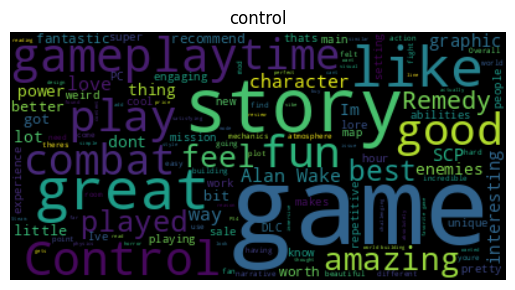

plagueTale usable reviews: 58


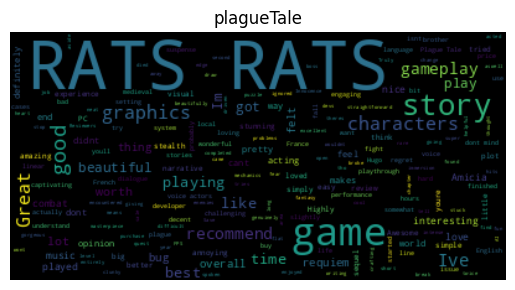

tombRaider usable reviews: 181


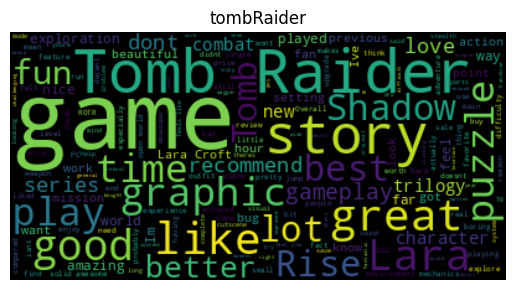

senuaSacrifice usable reviews: 72


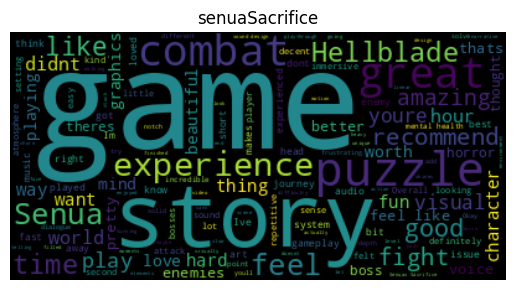

nierAutomata usable reviews: 300


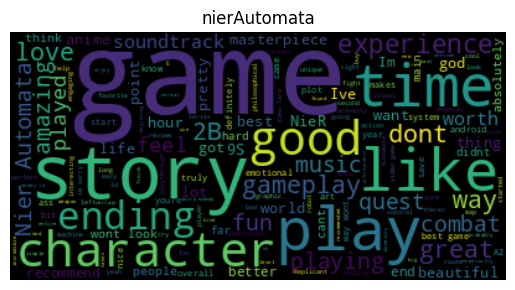

lifeIsStrangeRem usable reviews: 67


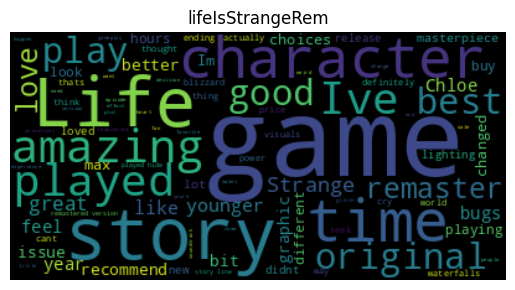

re4 usable reviews: 234


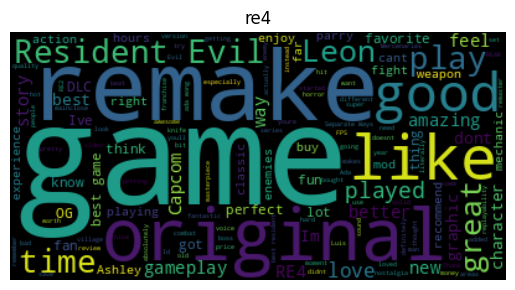

alanWake usable reviews: 49


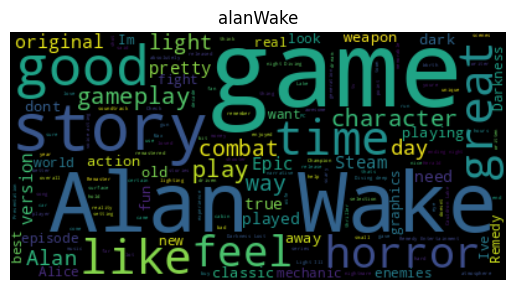

lifeIsStrange2 usable reviews: 44


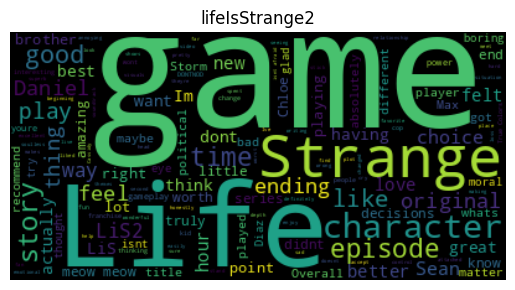

uncharted usable reviews: 29


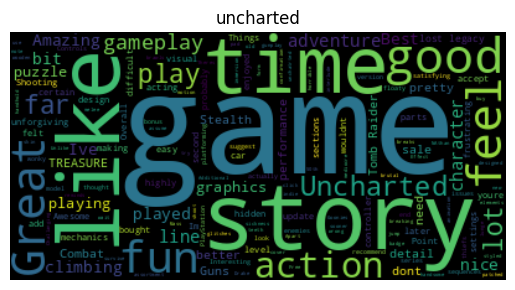

sekiro usable reviews: 910


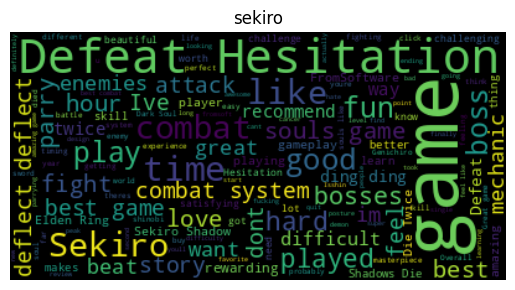

persona5 usable reviews: 0


In [7]:
def flatten(xss):
    return [x for xs in xss for x in xs]

spacyStopWords = stop_words.STOP_WORDS

for key,reviews in allGamesClean.items():
    allText = ""
    docBin = DocBin()
    for review in reviews:
        allText += f" {review[1]}"
        doc = nlp(review[1])
        doc.user_data = review[0]
        docBin.add(doc)
            
    #Interestingly persona5 has no usable reviews! This will probably warrant looking at the underlying data to verify
    usableReviews = len(list(docBin.get_docs(nlp.vocab)))
    print(f"{key} usable reviews: {usableReviews}")
    if usableReviews > 0:
        reviewContent = flatten(list(docBin.get_docs(nlp.vocab)))
        wordcloud = WordCloud(stopwords=spacyStopWords).generate(allText)
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"{key}")
        plt.show()